In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ptitprince as pt
import inspect

In [2]:
shared_control_ssrt = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_metrics_ssrt.csv")
simple_stop_ssrt = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/simple_stop_metrics.csv")
participant_tracking = pd.read_csv('/Users/kritiaxh/Documents/PoldrackLab/SharedControl/data/participant_tracking.csv')
survey_results = pd.read_csv('/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/survey_scores.csv')
go_task_accuracy_before_stop_onset = pd.read_csv('/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_metrics_go_task_accuracy_before_stop_onset.csv')
duration_of_inhibition = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_metrics_duration_of_inhibition.csv")
proportion_of_trials_with_stop_moment = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/proportion_of_trials_with_stop_moment.csv")
ssrt_first_half = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_ssrt_first_half.csv")
ssrt_second_half = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_ssrt_second_half.csv")

In [3]:
# Set the first column as the index to use for merging (assuming it's the subject ID)
shared_control_ssrt.columns = ['subject_id'] + list(shared_control_ssrt.columns[1:])
simple_stop_ssrt.columns = ['subject_id'] + list(simple_stop_ssrt.columns[1:])

# Merge by the first (subject_id) column
merged_df = pd.merge(shared_control_ssrt, simple_stop_ssrt[['subject_id', 'ssrt']], on='subject_id', how='left')

# Rename columns
merged_df.rename(columns={'ssrt': 'simple_stop_ssrt', 'ai_ssrt': 'ai_disengaged_ssrt', 'ai_ai_ssrt': 'ai_engaged_ssrt'}, inplace=True)

# Remove the last row, assuming it's the mean row
merged_df = merged_df.iloc[:-1, :]

In [4]:
mean_df = np.mean(merged_df["ai_disengaged_ssrt"])
mean_std = np.std(merged_df["ai_disengaged_ssrt"])
print(mean_df, mean_std)
print(mean_df + 3*mean_std)
print((merged_df["non_ai_ssrt"] > merged_df["ai_disengaged_ssrt"]).sum())

0.2643050706704904 0.033682721775272935
0.3653532359963092
5


## Planned Statistical Tests

In [5]:
# Reshape the data for repeated measures ANOVA
data_long = pd.melt(merged_df, id_vars=['subject_id'], value_vars=['non_ai_ssrt', 'ai_disengaged_ssrt', 'simple_stop_ssrt'],
                    var_name='condition', value_name='SSRT')


# Run the repeated measures ANOVA
aovrm = AnovaRM(data_long, 'SSRT', 'subject_id', within=['condition'])
anova_results = aovrm.fit()

In [6]:
# Conduct the paired t-tests for planned comparisons

# Comparison 1: AI Stop vs non-AI Stop
ai_vs_non_ai = stats.ttest_rel(merged_df['ai_disengaged_ssrt'], merged_df['non_ai_ssrt'])
print(f"AI Disengaged vs Non-AI SSRT Comparison: t-statistic = {ai_vs_non_ai.statistic}, p-value = {ai_vs_non_ai.pvalue}")

# Comparison 2: Non-AI vs Simple Stopping
non_ai_vs_simple = stats.ttest_rel(merged_df['non_ai_ssrt'], merged_df['simple_stop_ssrt'])
non_ai_vs_simple_corr = np.corrcoef(merged_df['non_ai_ssrt'], merged_df['simple_stop_ssrt'])[1][0]
print(f"Non-AI vs Simple Stopping SSRT Comparison: t-statistic = {non_ai_vs_simple.statistic}, p-value = {non_ai_vs_simple.pvalue}")
print(non_ai_vs_simple_corr)

AI Disengaged vs Non-AI SSRT Comparison: t-statistic = 5.550805956671271, p-value = 2.1770972122231842e-06
Non-AI vs Simple Stopping SSRT Comparison: t-statistic = 5.719036142355336, p-value = 1.2720070534575027e-06
0.4893609398722145


## Order Effects

In [7]:
# Calculate order effects between AI being first or Non-AI being first
non_ai_first_subs = participant_tracking[participant_tracking["Cond Order"] == 1]["Subject"].to_list()
ai_first_subs = participant_tracking[participant_tracking["Cond Order"] == 2]["Subject"].to_list()

ssrt_non_ai_first_non_ai = []
ssrt_ai_first_non_ai = []
ssrt_non_ai_first_ai = []
ssrt_ai_first_ai = []
ssrt_non_ai_first_ai_ai = []
ssrt_ai_first_ai_ai = []

for sub in non_ai_first_subs:
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["non_ai_ssrt"].values
    ssrt_non_ai_first_non_ai.append(ssrt[0])
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["ai_ssrt"].values
    ssrt_non_ai_first_ai.append(ssrt[0])
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["ai_ai_ssrt"].values
    ssrt_non_ai_first_ai_ai.append(ssrt[0])

for sub in ai_first_subs:
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["non_ai_ssrt"].values
    ssrt_ai_first_non_ai.append(ssrt[0])
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["ai_ssrt"].values
    ssrt_ai_first_ai.append(ssrt[0])
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["ai_ai_ssrt"].values
    ssrt_ai_first_ai_ai.append(ssrt[0])

t_stat, p_value = stats.ttest_ind(ssrt_ai_first_non_ai, ssrt_non_ai_first_non_ai, equal_var=False)
print(f'Non AI SSRT: {t_stat}, {p_value}')
t_stat, p_value = stats.ttest_ind(ssrt_ai_first_ai, ssrt_non_ai_first_ai, equal_var=False)
print(f'AI SSRT: {t_stat}, {p_value}')
t_stat, p_value = stats.ttest_ind(ssrt_ai_first_ai_ai, ssrt_non_ai_first_ai_ai, equal_var=False)
print(f'AI AI SSRT: {t_stat}, {p_value}')

# Calculate the differences between AI SSRT and Non-AI SSRT for both subject groups
diff_non_ai_first = np.array(ssrt_non_ai_first_ai) - np.array(ssrt_non_ai_first_non_ai)  # AI - Non-AI for Non-AI first subjects
diff_ai_first = np.array(ssrt_ai_first_ai) - np.array(ssrt_ai_first_non_ai)  # AI - Non-AI for AI first subjects
t_stat_diff, p_value_diff = stats.ttest_ind(diff_ai_first, diff_non_ai_first, equal_var=False)
print(f'T-statistic for AI - Non-AI difference between groups: {t_stat_diff:.2f}, P-value: {p_value_diff:.4f}')

Non AI SSRT: 1.1982516176222238, 0.23824410656420641
AI SSRT: 1.249715821063293, 0.21918472730008018
AI AI SSRT: -0.24238877819331422, 0.8101135180033848
T-statistic for AI - Non-AI difference between groups: 0.47, P-value: 0.6435


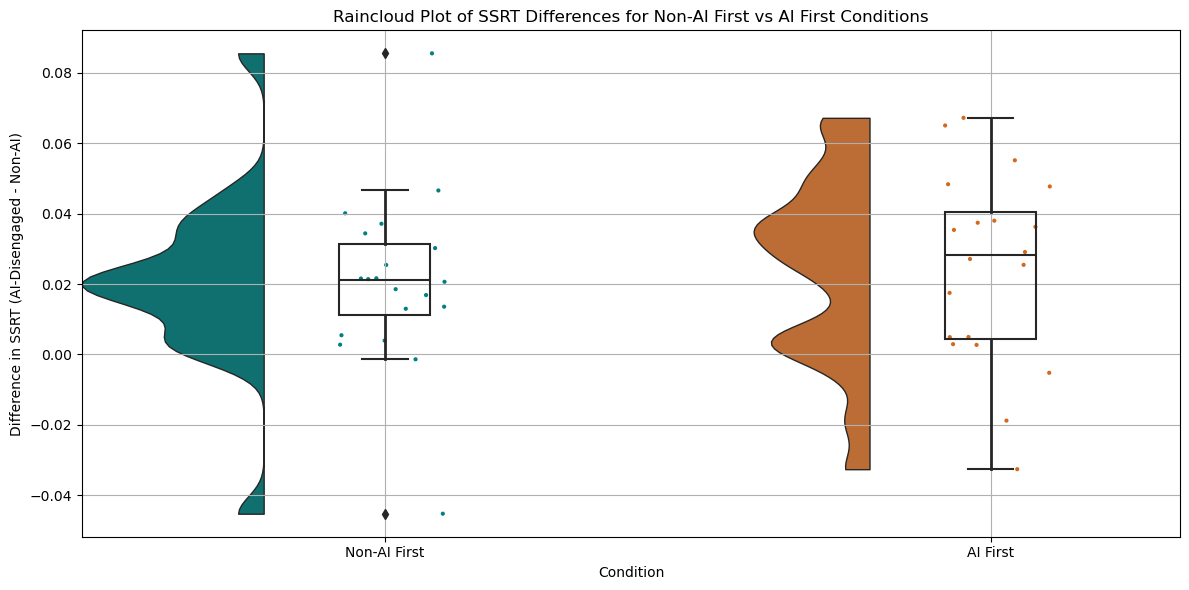

In [8]:
# Create a raincloud plot of Difference in AI - Non AI SSRT for subjects who had the AI block first vs Non AI block first
data_to_plot = {
    'Condition': ['Non-AI First'] * len(diff_non_ai_first) + ['AI First'] * len(diff_ai_first),
    'Difference': np.concatenate((diff_non_ai_first, diff_ai_first))
}

# Create the DataFrame
plot_df = pd.DataFrame(data_to_plot)

# Set up the figure for the raincloud plots
plt.figure(figsize=(12, 6))

# Create the raincloud plot
ax = plt.gca()  # Get the current axes
raincloud = pt.RainCloud(
    x='Condition', 
    y='Difference', 
    data=plot_df,
    palette={"Non-AI First": "teal", 
             "AI First": "chocolate"},
    width_viol=0.6, 
    ax=ax
)

# Add titles and labels
ax.set_title('Raincloud Plot of SSRT Differences for Non-AI First vs AI First Conditions')
ax.set_xlabel('Condition')
ax.set_ylabel('Difference in SSRT (AI-Disengaged - Non-AI)')
ax.grid()

# Save and show the plot
plt.tight_layout()
plt.savefig('figures/order_effects_raincloud_plot.png', dpi=300)
plt.show()

In [9]:
# T test for AI vs Non AI SSRT in the first half of trials
ai_vs_non_ai = stats.ttest_rel(ssrt_first_half['ai_ssrt_first_half'], ssrt_first_half['non_ai_ssrt_first_half'])
print(f"AI Disengaged vs Non-AI SSRT Comparison in the first half of trials: t-statistic = {ai_vs_non_ai.statistic}, p-value = {ai_vs_non_ai.pvalue}")

AI Disengaged vs Non-AI SSRT Comparison in the first half of trials: t-statistic = 3.5954701082655167, p-value = 0.0008793461233483437


In [10]:
# T test for AI vs Non AI SSRT in the second half of all trials
ai_vs_non_ai = stats.ttest_rel(ssrt_second_half['ai_ssrt_second_half'], ssrt_second_half['non_ai_ssrt_second_half'])
print(f"AI Disengaged vs Non-AI SSRT Comparison in the second half of trials: t-statistic = {ai_vs_non_ai.statistic}, p-value = {ai_vs_non_ai.pvalue}")

AI Disengaged vs Non-AI SSRT Comparison in the second half of trials: t-statistic = 4.296211280868575, p-value = 0.00010783918797982742


## Create plots for QA

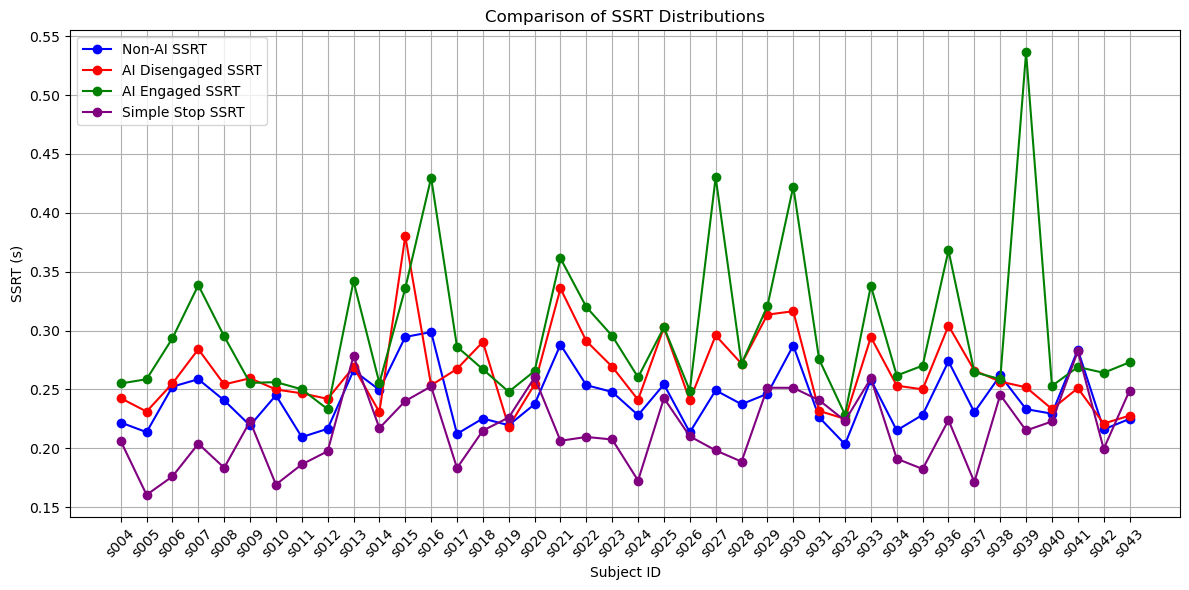

In [11]:
#Create a line plot of SSRT
# Plotting the SSRT distributions together
plt.figure(figsize=(12, 6))

# Plot each condition's SSRT on the same axes
plt.plot(merged_df['subject_id'], merged_df['non_ai_ssrt'], label='Non-AI SSRT', marker='o', color='blue')
plt.plot(merged_df['subject_id'], merged_df['ai_disengaged_ssrt'], label='AI Disengaged SSRT', marker='o', color='red')
plt.plot(merged_df['subject_id'], merged_df['ai_engaged_ssrt'], label='AI Engaged SSRT', marker='o', color='green')
plt.plot(merged_df['subject_id'], merged_df['simple_stop_ssrt'], label='Simple Stop SSRT', marker='o', color='purple')

# Titles and labels
plt.title('Comparison of SSRT Distributions')
plt.xlabel('Subject ID')
plt.ylabel('SSRT (s)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()

# Save the figure and show
plt.savefig('figures/ssrt_distributions_comparison.png', dpi=300)
plt.show()

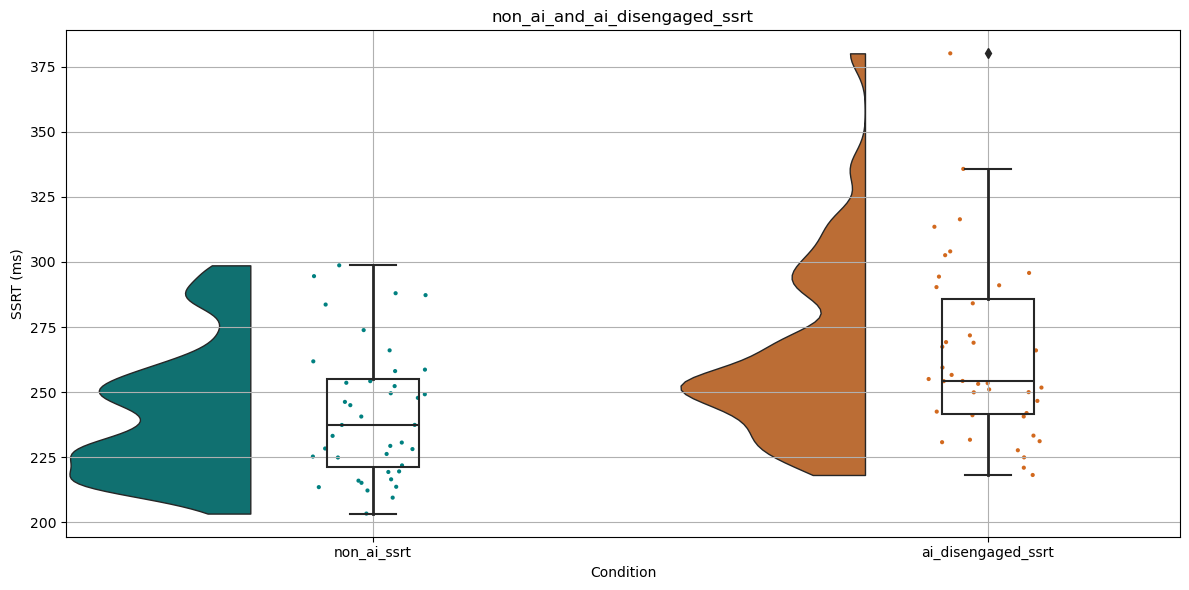

In [12]:
# Raincloud plot for AI vs Non AI SSRT
# Set up the figure for the raincloud plots
plt.figure(figsize=(12, 6))

# Combine the data into a long format suitable for Seaborn
melted_df = merged_df.melt(id_vars='subject_id', value_vars=['non_ai_ssrt', 'ai_disengaged_ssrt'],
                            var_name='Condition', value_name='SSRT')
melted_df['SSRT'] *= 1000  # Convert to milliseconds

# Create a new axis for the plot
ax = plt.gca()  # Get the current axes

# Create the raincloud plot
raincloud = pt.RainCloud(x='Condition', y='SSRT', data=melted_df,
                          palette={"non_ai_ssrt": "teal", "ai_disengaged_ssrt": "chocolate"},
                          width_viol=0.6, ax=ax)

# Add titles and labels
ax.set_title('non_ai_and_ai_disengaged_ssrt')
ax.set_xlabel('Condition')
ax.set_ylabel('SSRT (ms)')
ax.grid()

# Save and show the plot
plt.tight_layout()
plt.savefig('figures/ai_disengaged_vs_non_ai_ssrt_raincloud_plots.png', dpi=300)
plt.show()

/opt/homebrew/anaconda3/lib/python3.12/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/lib/python3.12/site

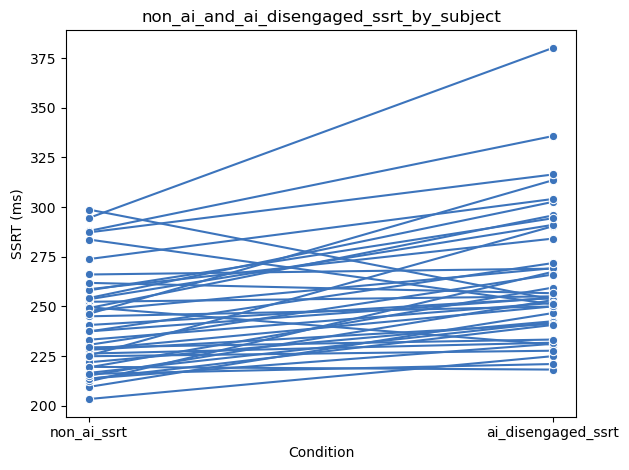

In [13]:
ax = sns.lineplot(x='Condition', y='SSRT', data=melted_df, hue='subject_id', marker='o',
                  palette=['#3C74BC'] * len(melted_df['subject_id'].unique()), legend=False)
ax.set_title('non_ai_and_ai_disengaged_ssrt_by_subject')
ax.set_ylabel('SSRT (ms)')
plt.tight_layout()
plt.savefig('figures/non_ai_and_ai_disengaged_ssrt_by_subject.png', dpi=300)
plt.show()

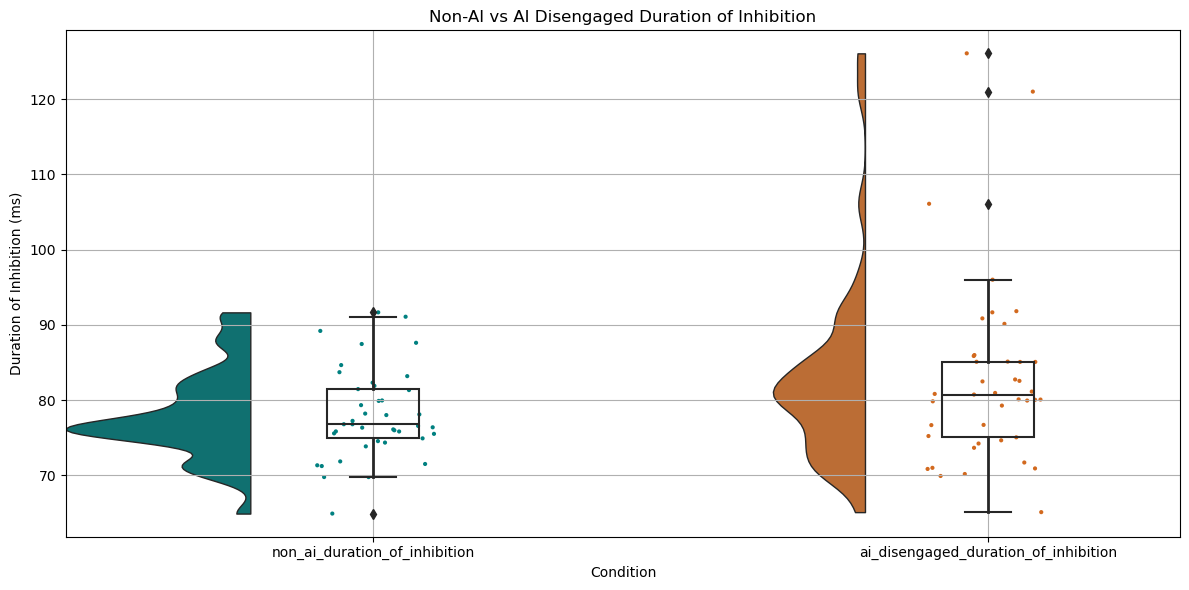

In [14]:
duration_of_inhibition.reset_index(inplace=True)
duration_of_inhibition.rename(columns={duration_of_inhibition.columns[0]: 'subject_id',
                                       'ai_duration_of_inhibition': 'ai_disengaged_duration_of_inhibition'}, inplace=True)

melted_df = duration_of_inhibition.melt(
    id_vars='subject_id', 
    value_vars=[
        'non_ai_duration_of_inhibition', 
        'ai_disengaged_duration_of_inhibition'
    ],
    var_name='Condition', 
    value_name='Duration of Inhibition'
)

melted_df['Duration of Inhibition'] *= 1000  # Convert to milliseconds

plt.figure(figsize=(12, 6))

# Create the raincloud plot
ax = plt.gca()  # Get the current axes
raincloud = pt.RainCloud(
    x='Condition', 
    y='Duration of Inhibition', 
    data=melted_df,
    palette={"non_ai_duration_of_inhibition": "teal", 
             "ai_disengaged_duration_of_inhibition": "chocolate"},
    width_viol=0.6, 
    ax=ax
)

# Add titles and labels
ax.set_title('Non-AI vs AI Disengaged Duration of Inhibition')
ax.set_xlabel('Condition')
ax.set_ylabel('Duration of Inhibition (ms)')
ax.grid()

# Save and show the plot
plt.tight_layout()
plt.savefig('figures/non_ai_vs_ai_duration_of_inhibition_raincloud_plots.png', dpi=300)
plt.show()

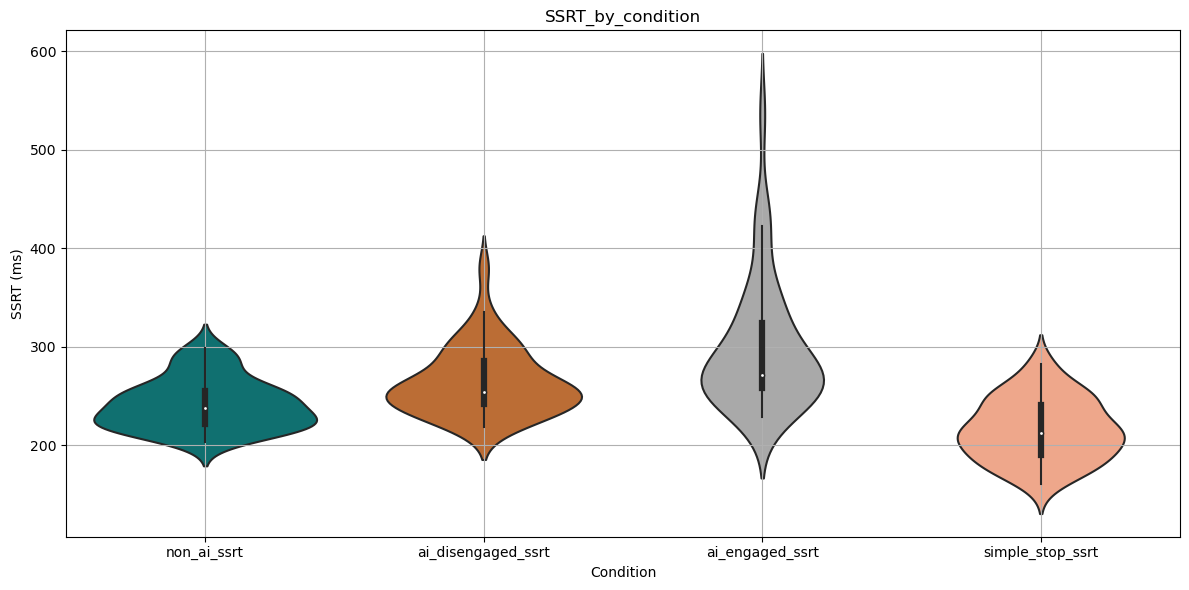

In [15]:
#Create violin plots of all SSRT
# Set up the figure for the violin plots
plt.figure(figsize=(12, 6))

# Combine the data into a long format suitable for Seaborn
melted_df = merged_df.melt(id_vars='subject_id', value_vars=['non_ai_ssrt', 'ai_disengaged_ssrt', 'ai_engaged_ssrt', 'simple_stop_ssrt'],
                            var_name='Condition', value_name='SSRT')
melted_df['SSRT'] *= 1000
# Create violin plots
sns.violinplot(x='Condition', y='SSRT', data=melted_df, palette={"non_ai_ssrt": "teal", "ai_disengaged_ssrt": "chocolate", 'ai_engaged_ssrt': "darkgray", 'simple_stop_ssrt': "lightsalmon"})

# Add titles and labels
plt.title('SSRT_by_condition')
plt.xlabel('Condition')
plt.ylabel('SSRT (ms)')
plt.grid()

# Save and show the plot
plt.tight_layout()
plt.savefig('figures/all_ssrt_violin_plots.png', dpi=300)
plt.show()

In [16]:
def create_raincloud_plot(df, y_axis_name, multiply=0):
    """
    Create a raincloud plot for proportions of trials with stop moments by condition.

    Parameters:
    - df: The DataFrame containing the data.
    - y_axis_name: Name of y axis
    """
    frame_name = [name for name, val in inspect.currentframe().f_back.f_locals.items() if val is df][0]
    # Set up the figure for the raincloud plots
    plt.figure(figsize=(12, 6))

    # Reset index
    df.reset_index(inplace=True)

    # Rename specific columns
    new_columns = list(df.columns)
    new_columns[1] = 'subject_id'  # Ensure 3rd column is subject_id
    new_columns[2] = 'non_ai'  # Rename 5th column to non_ai
    new_columns[3] = 'ai_disengaged'  # Rename 6th column to ai_disengaged
    new_columns[4] = 'ai_engaged'  # Rename 7th column to ai_engaged
    df.columns = new_columns  # Assign new column names

    # Melt the dataframe to long format
    melted_df = df.melt(
        id_vars='subject_id', 
        value_vars=['non_ai', 'ai_disengaged', 'ai_engaged'],
        var_name='Condition', 
        value_name=y_axis_name
    )

    if multiply == 1:
        melted_df[y_axis_name] *= 1000

    # Create the raincloud plot
    ax = plt.gca()  # Get the current axes
    raincloud = pt.RainCloud(
        x='Condition', 
        y=y_axis_name, 
        data=melted_df,
        palette={"non_ai": "teal", 
                 "ai_disengaged": "chocolate", 
                 "ai_engaged": "darkgray"},
        width_viol=0.6, 
        ax=ax
    )

    # Add titles and labels
    ax.set_title(f'{frame_name}')
    ax.set_xlabel('Condition')
    ax.set_ylabel(y_axis_name)
    ax.grid()

    # Save and show the plot
    plt.tight_layout()
    plt.savefig(f'figures/{frame_name}.png', dpi=300)
    plt.show()
    
    print(f"Raincloud plot saved as {frame_name}")

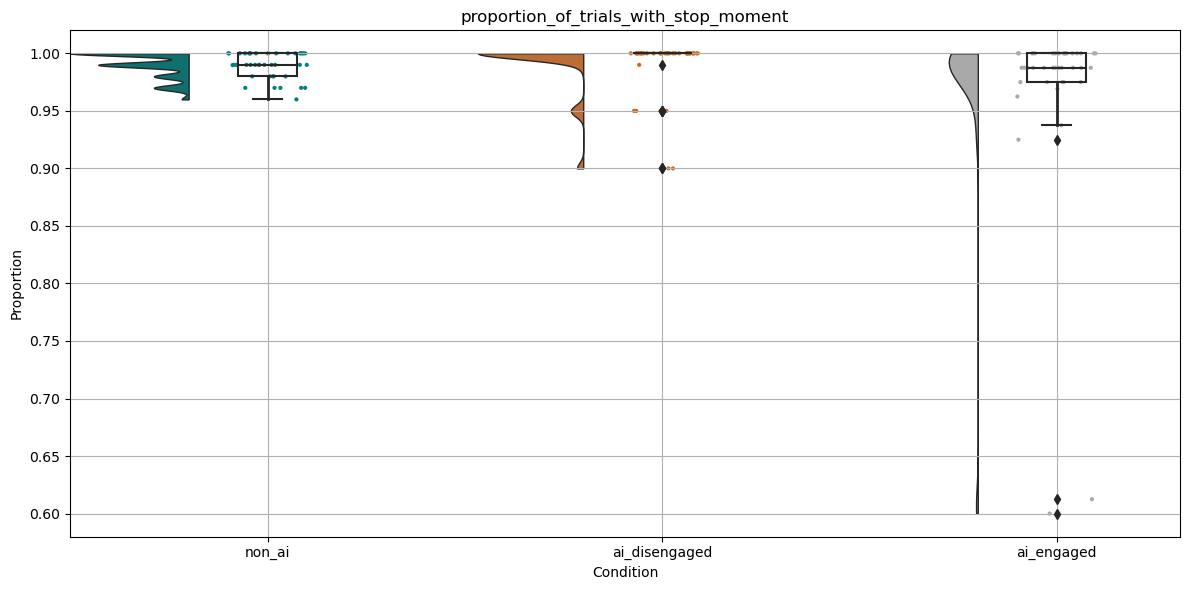

Raincloud plot saved as proportion_of_trials_with_stop_moment


In [17]:
create_raincloud_plot(proportion_of_trials_with_stop_moment, 'Proportion')

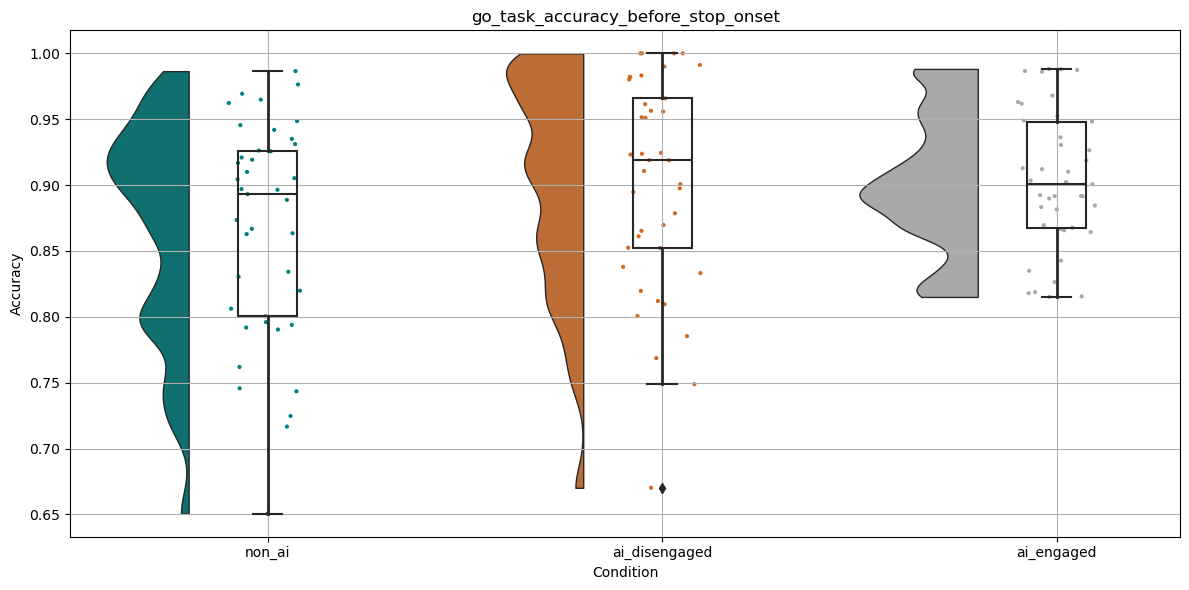

Raincloud plot saved as go_task_accuracy_before_stop_onset


In [18]:
create_raincloud_plot(go_task_accuracy_before_stop_onset, 'Accuracy')

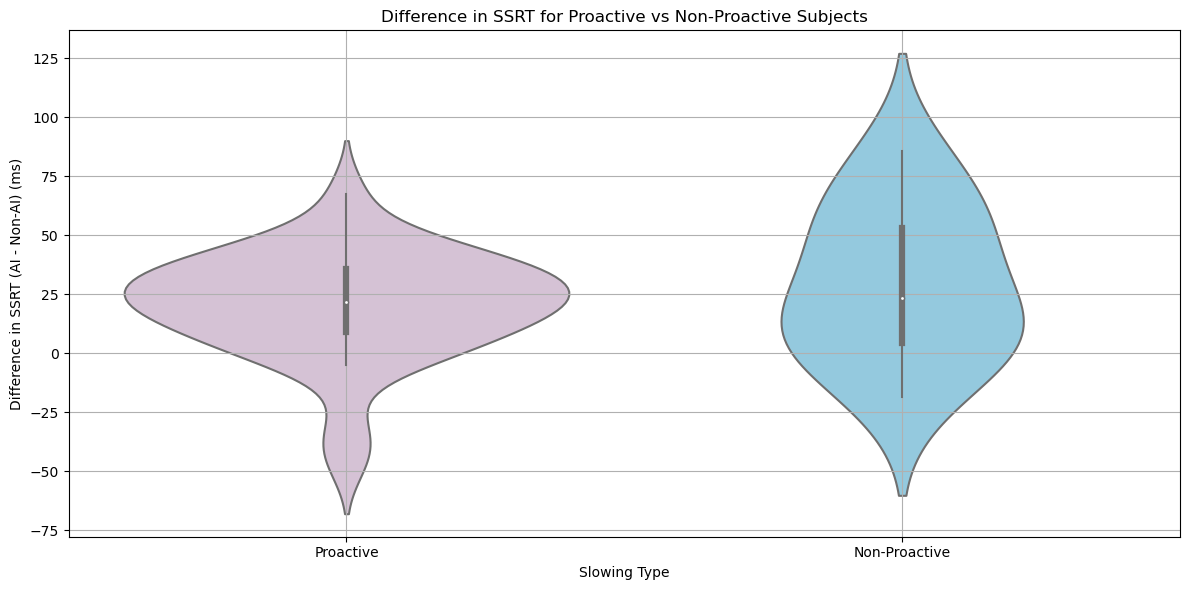

In [19]:
#Create violin plots of AI - Non AI SSRT in proactive vs non-proactive slowing subjects

# Identify non-proactive slowing subjects
non_proactive_slowing_subs = (go_task_accuracy_before_stop_onset['non_ai'] > 
                              go_task_accuracy_before_stop_onset['ai_disengaged'])
non_proactive_subjects = go_task_accuracy_before_stop_onset.index[non_proactive_slowing_subs].tolist()

# Extract SSRT values for AI and Non-AI conditions
ssrt_non_ai = shared_control_ssrt['non_ai_ssrt']
ssrt_ai = shared_control_ssrt['ai_ssrt']

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'subject_id': shared_control_ssrt.index,
    'ssrt_non_ai': ssrt_non_ai,
    'ssrt_ai': ssrt_ai
})

# Calculate the difference between AI SSRT and Non-AI SSRT
plot_data['difference'] = plot_data['ssrt_ai'] - plot_data['ssrt_non_ai']

# Classify subjects based on proactive slowing
plot_data['slowing_type'] = ['Non-Proactive' if subject in non_proactive_subjects else 'Proactive' 
                              for subject in plot_data['subject_id']]

plot_data['difference_ms'] = plot_data['difference'] * 1000

violin_data = plot_data[['difference_ms', 'slowing_type']]
plt.figure(figsize=(12, 6))
sns.violinplot(x='slowing_type', y='difference_ms', data=violin_data, palette={'Non-Proactive': 'skyblue', 'Proactive': 'thistle'})
plt.title('Difference in SSRT for Proactive vs Non-Proactive Subjects')
plt.xlabel('Slowing Type')
plt.ylabel('Difference in SSRT (AI - Non-AI) (ms)')
plt.grid()
plt.tight_layout()
plt.savefig('figures/ssrt_difference_proactive_vs_non_proactive.png', dpi=300) 
plt.show()

/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_28381/3042784272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_proactive_slowing_data.rename(columns={'ssrt_ai': 'ssrt_ai_disengaged'}, inplace=True)


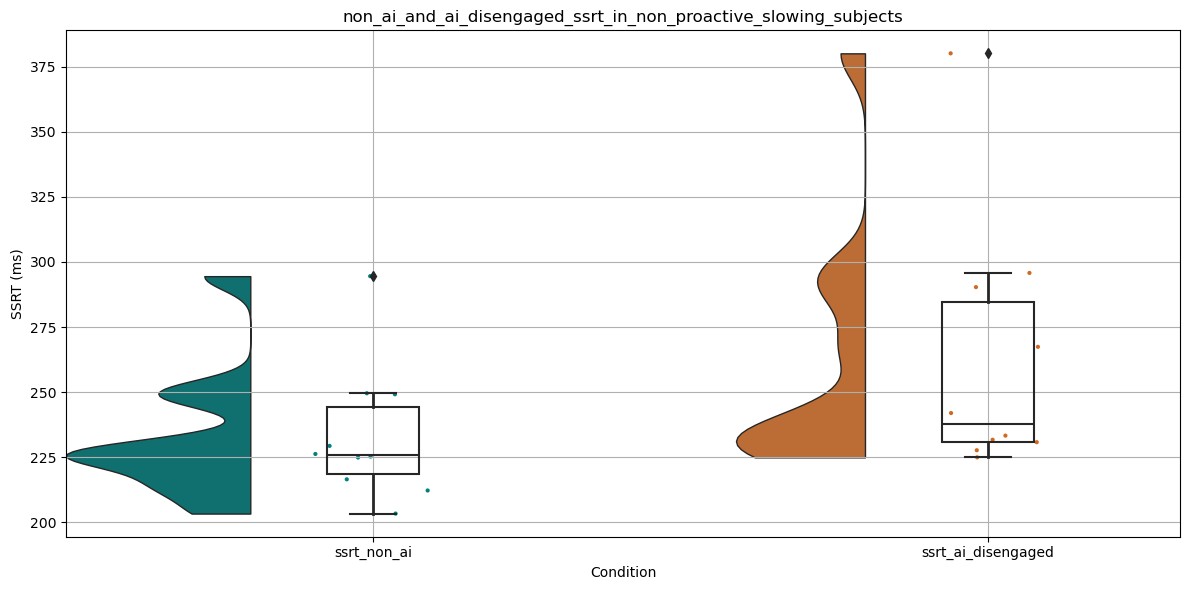

In [20]:
plt.figure(figsize=(12, 6))
non_proactive_slowing_data = plot_data[plot_data['slowing_type'] == 'Non-Proactive']
# Combine the data into a long format suitable for Seaborn
non_proactive_slowing_data.rename(columns={'ssrt_ai': 'ssrt_ai_disengaged'}, inplace=True)
melted_df = non_proactive_slowing_data.melt(id_vars='subject_id', value_vars=['ssrt_non_ai', 'ssrt_ai_disengaged'],
                            var_name='Condition', value_name='SSRT')
melted_df['SSRT'] *= 1000  # Convert to milliseconds

# Create a new axis for the plot
ax = plt.gca()  # Get the current axes

# Create the raincloud plot
raincloud = pt.RainCloud(x='Condition', y='SSRT', data=melted_df,
                          palette={"ssrt_non_ai": "teal", "ssrt_ai_disengaged": "chocolate"},
                          width_viol=0.6, ax=ax)

# Add titles and labels
ax.set_title('non_ai_and_ai_disengaged_ssrt_in_non_proactive_slowing_subjects')
ax.set_xlabel('Condition')
ax.set_ylabel('SSRT (ms)')
ax.grid()

# Save and show the plot
plt.tight_layout()
plt.savefig('figures/non_ai_and_ai_disengaged_ssrt_in_non_proactive_slowing_subjects.png', dpi=300)
plt.show()

## Exploratory T-tests

In [21]:
# T test for AI vs Non AI Duration of inhibition
t_stat, p_value = stats.ttest_rel(duration_of_inhibition['non_ai_duration_of_inhibition'], duration_of_inhibition['ai_disengaged_duration_of_inhibition'])
# Print the t-statistic and p-value
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")

T-statistic: -2.898, P-value: 0.0061


In [22]:
# T test for AI vs Non AI Go task accuracy before stop onset
t_stat, p_value = stats.ttest_rel(go_task_accuracy_before_stop_onset['non_ai'], go_task_accuracy_before_stop_onset['ai_disengaged'])

# Print the t-statistic and p-value
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")

T-statistic: -2.877, P-value: 0.0064


In [23]:
# T-test for difference in Non AI and AI SSRT in subjects who didn't show proactive slowing
t_stat, p_value = stats.ttest_rel(non_proactive_slowing_data['ssrt_non_ai'], non_proactive_slowing_data['ssrt_ai_disengaged'])
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")

T-statistic: -2.819, P-value: 0.0201


In [24]:
#T test for difference between Non AI and AI SSRT in subjects who showed and didn't show proactive slowing
non_proactive_differences = plot_data[plot_data['slowing_type'] == 'Non-Proactive']['difference_ms']
proactive_differences = plot_data[plot_data['slowing_type'] == 'Proactive']['difference_ms']
print(np.mean(non_proactive_differences), np.mean(proactive_differences))
t_stat, p_value = stats.ttest_ind(non_proactive_differences, proactive_differences, nan_policy='omit')
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")

29.29081116346714 20.35843939220973
T-statistic: 0.97, P-value: 0.3390


## Correlate and plot survey scores

In [25]:
def correlate_and_plot_survey_scores(column_name):
    #Find the correlation between the survey score and the difference between AI Stop SSRT and Non AI SSRT for each subject
    # Merge without duplicates
    avg_df = merged_df.merge(survey_results, on='subject_id', how='left')

    # Compute the difference between ai and non-ai SSRT
    avg_df['difference_ai_disengaged_and_non_ai_ssrt'] = avg_df['ai_disengaged_ssrt'] - avg_df['non_ai_ssrt']

    # Compute the correlation
    correlation, pval = stats.pearsonr(avg_df["difference_ai_disengaged_and_non_ai_ssrt"], avg_df[column_name])
    print(f"Correlation and p-value between SSRT and survey scores: {correlation}, {pval}")

    avg_df.to_csv(f'/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/{column_name}_survey_by_ssrt.csv')

    avg_df['difference_ai_disengaged_and_non_ai_ssrt'] *= 1000 #convert to ms

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(avg_df['difference_ai_disengaged_and_non_ai_ssrt'], avg_df['average_score'], alpha=0.7)
    plt.title(f'Scatter Plot: {column_name} by SSRT')
    plt.xlabel('Difference between AI-Disengaged and Non AI SSRT (ms)')
    plt.ylabel('Survey Scores')
    plt.grid()
    plt.axhline(0, color='red', linestyle='--')  # Optional: Add a line at y = 0 for reference
    plt.axvline(0, color='red', linestyle='--')  # Optional: Add a line at x = 0 for reference
    plt.tight_layout()
    plt.savefig(f'/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/figures/{column_name}_survey_by_ssrt.png', dpi=300)
    plt.show()

Correlation and p-value between SSRT and survey scores: -0.06597909460779379, 0.6858469186225564


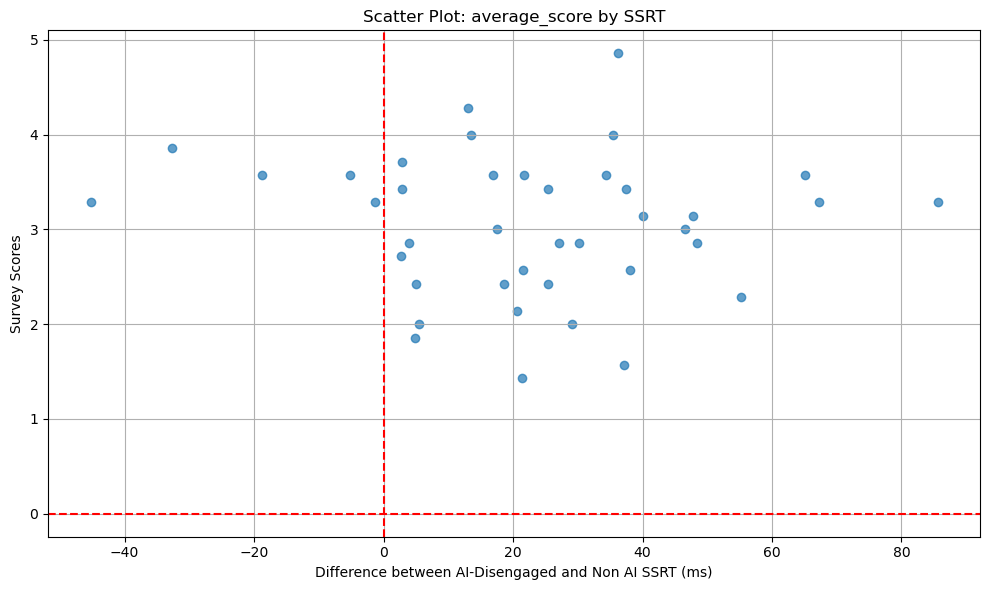

In [26]:
correlate_and_plot_survey_scores('average_score')

Correlation and p-value between SSRT and survey scores: -0.06597909460779378, 0.6858469186225564


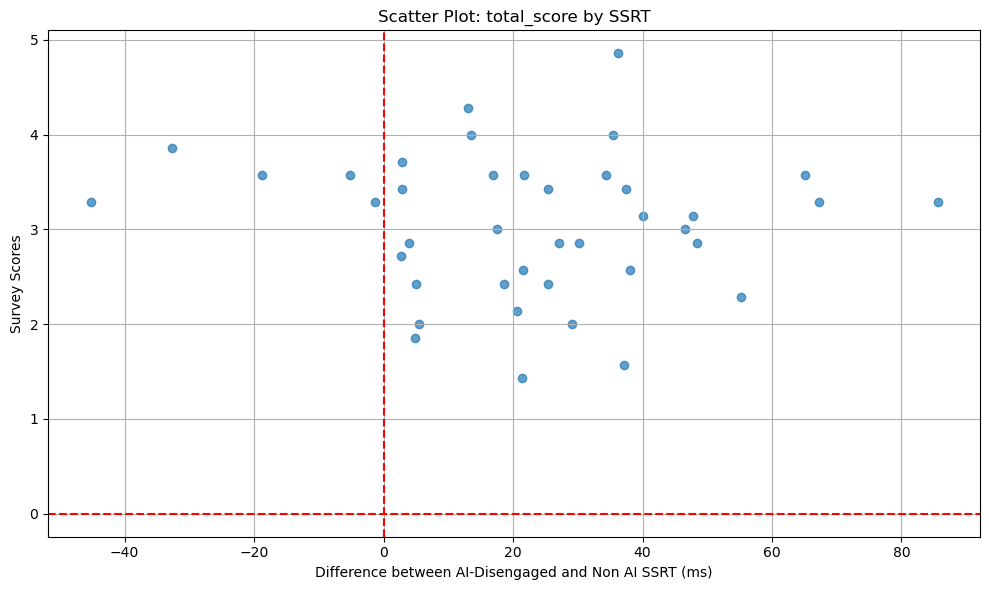

In [27]:
correlate_and_plot_survey_scores('total_score')

Correlation and p-value between SSRT and survey scores: -0.1834382326645837, 0.25720453596958015


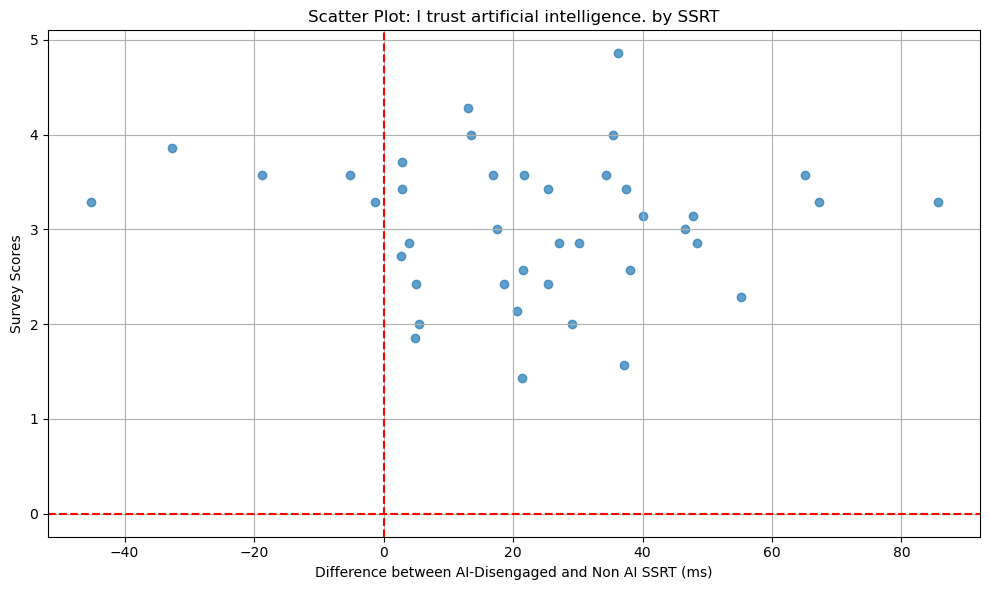

In [28]:
correlate_and_plot_survey_scores('I trust artificial intelligence.')

Correlation and p-value between SSRT and survey scores: 0.08523735256161273, 0.6010109752075908


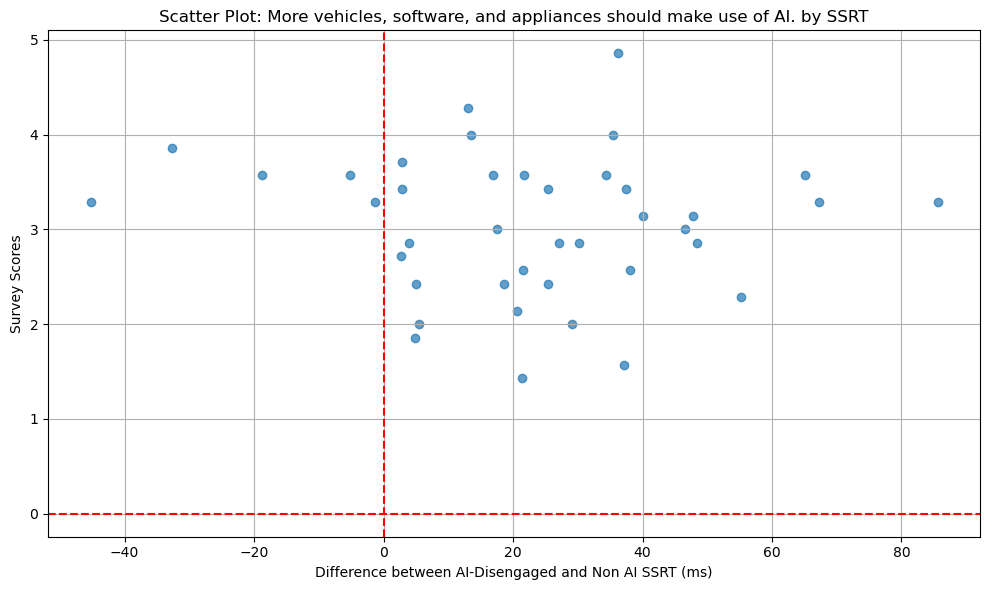

In [29]:
correlate_and_plot_survey_scores('More vehicles, software, and appliances should make use of AI.')

Correlation and p-value between SSRT and survey scores: 0.20611843529654922, 0.20194711841079052


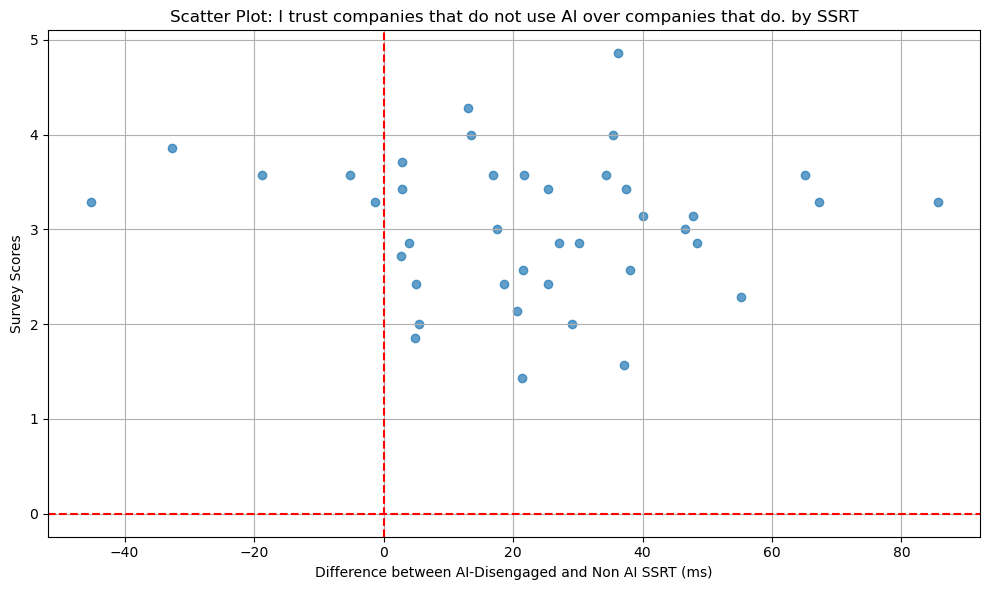

In [30]:
correlate_and_plot_survey_scores('I trust companies that do not use AI over companies that do.')

Correlation and p-value between SSRT and survey scores: -0.03945110637960794, 0.8090182651590193


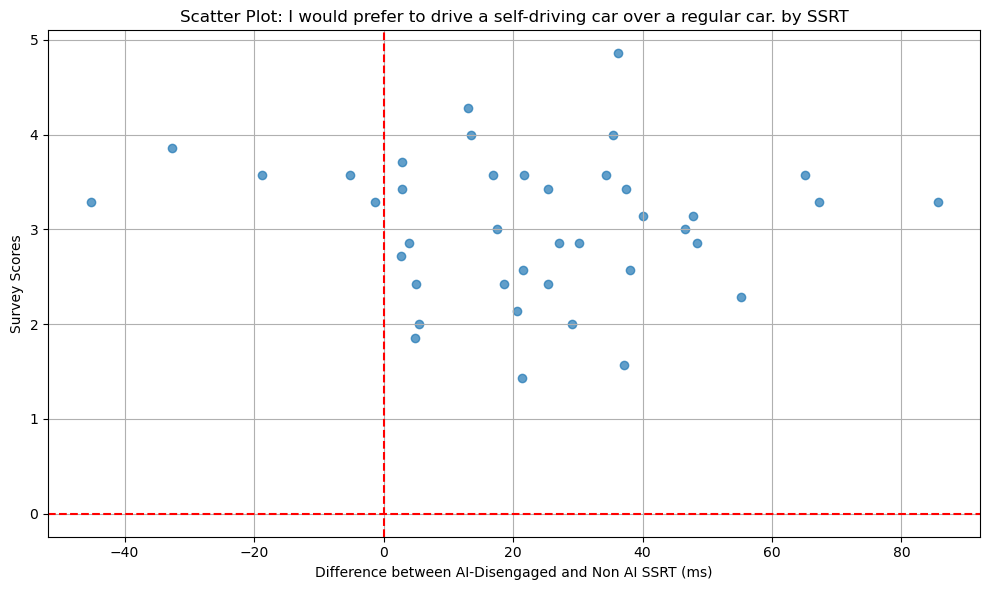

In [31]:
correlate_and_plot_survey_scores('I would prefer to drive a self-driving car over a regular car.')

Correlation and p-value between SSRT and survey scores: -0.09037627815488676, 0.5791671176650455


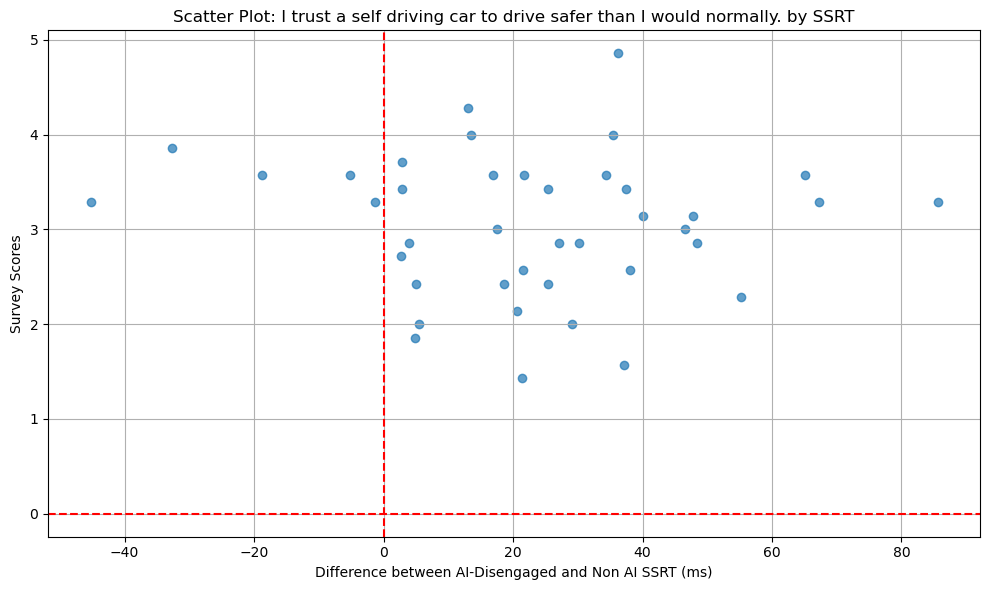

In [32]:
correlate_and_plot_survey_scores('I trust a self driving car to drive safer than I would normally.')

Correlation and p-value between SSRT and survey scores: -0.19413676613231323, 0.2300014221906248


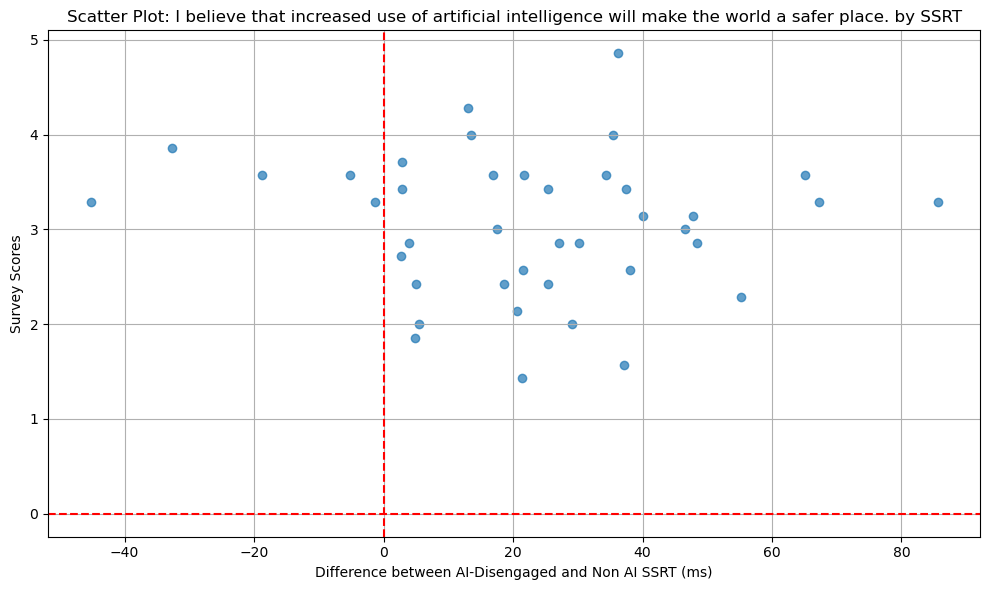

In [33]:
correlate_and_plot_survey_scores('I believe that increased use of artificial intelligence will make the world a safer place.')

Correlation and p-value between SSRT and survey scores: -0.07044367222878949, 0.6657889367507503


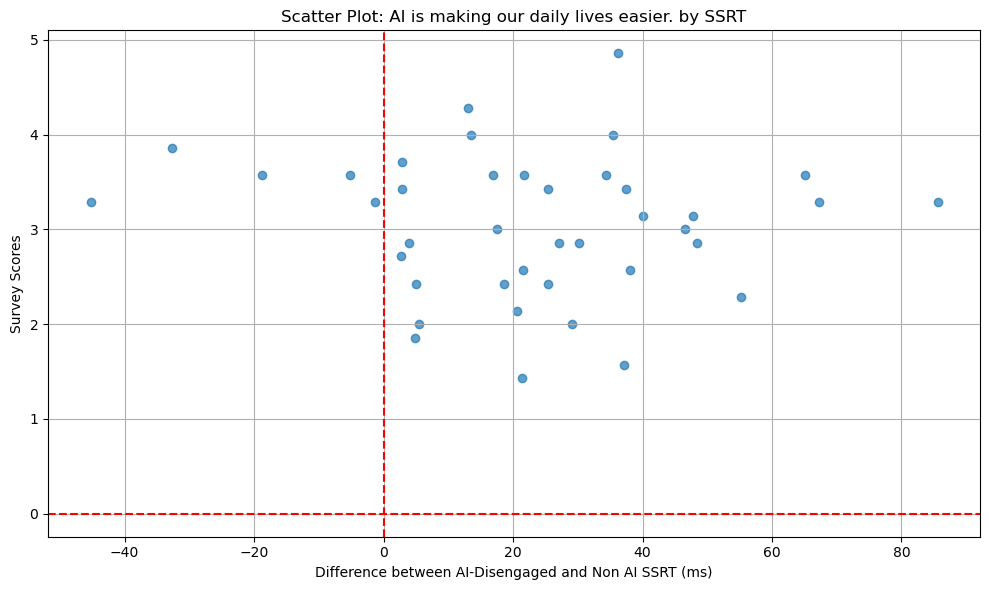

In [34]:
correlate_and_plot_survey_scores('AI is making our daily lives easier.')

In [35]:
def frequency_of_responses_to_survey(column_name):
    """
    Generate a bar chart of responses for a specific survey question.
    
    Parameters:
    - column_name: The text of the survey question.
    - survey_results: A dictionary containing survey responses with subject ID mapping.
    """
    # Handle reverse coding for the specific question
    if column_name == "I trust companies that do not use AI over companies that do.":
        survey_results[column_name] = 6 - survey_results[column_name]

    response_counts = np.bincount(survey_results[column_name].dropna().astype(int), minlength=6)[1:]

    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(1, 6), response_counts, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xticks(np.arange(1, 6)) 
    plt.xlabel("Survey Response")
    plt.ylabel("Frequency")
    plt.title(f'{column_name}')
    plt.grid(axis='y')
    plt.savefig(f'figures/frequency_{column_name}')
    # Show the plot
    plt.tight_layout()
    plt.show()

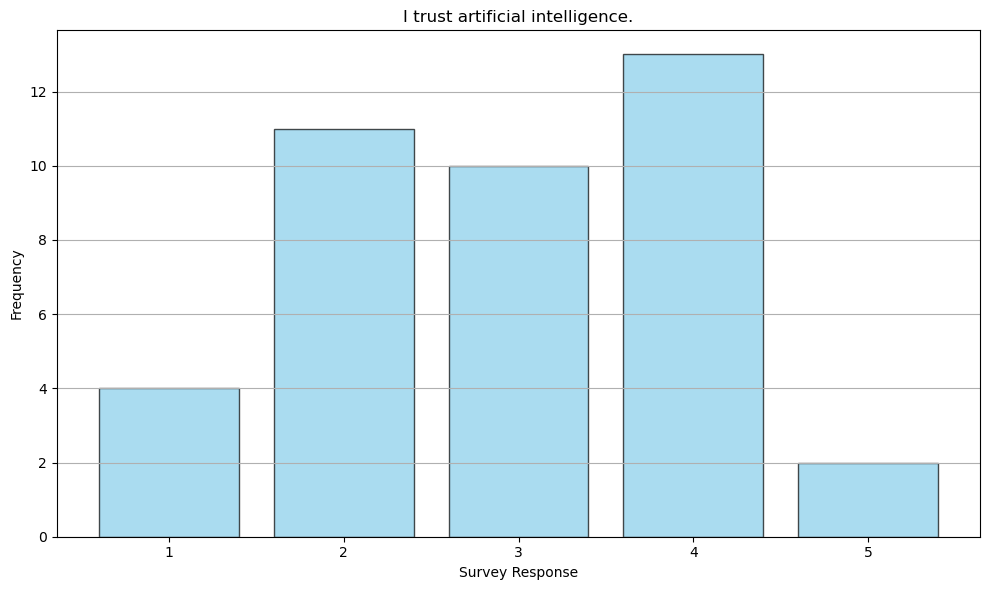

In [36]:
frequency_of_responses_to_survey('I trust artificial intelligence.')

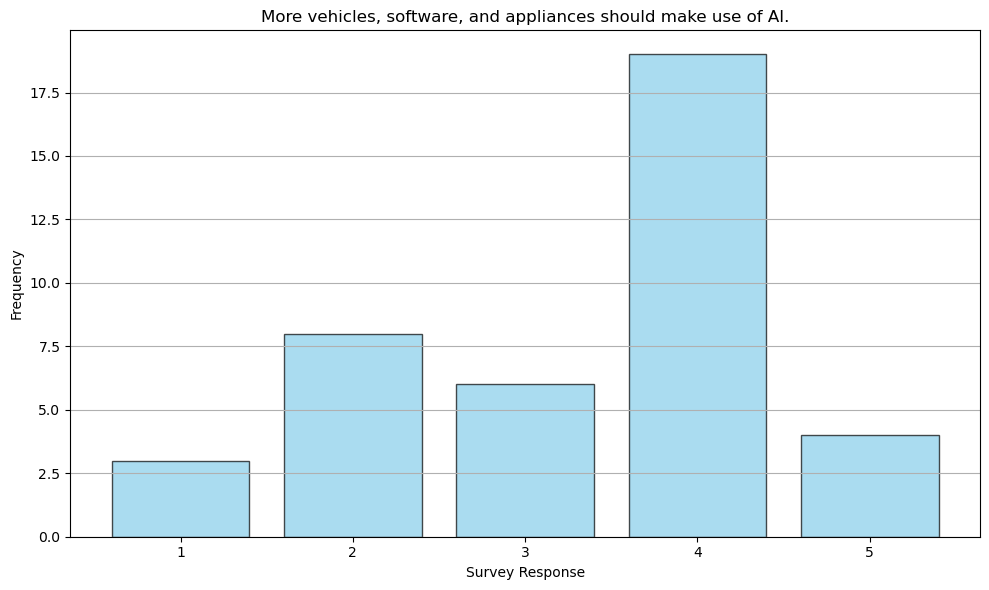

In [37]:
frequency_of_responses_to_survey('More vehicles, software, and appliances should make use of AI.')

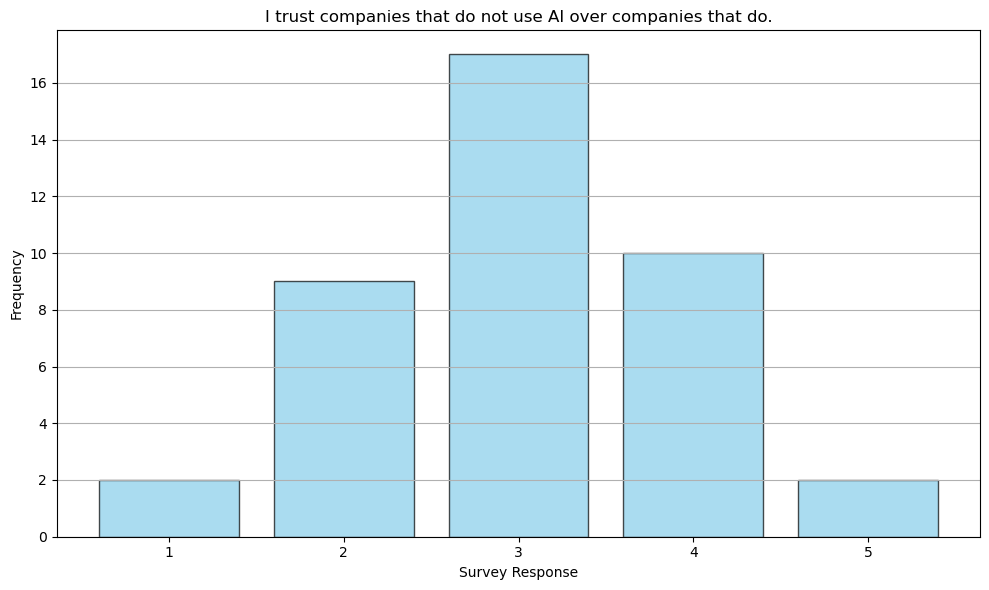

In [38]:
frequency_of_responses_to_survey('I trust companies that do not use AI over companies that do.')

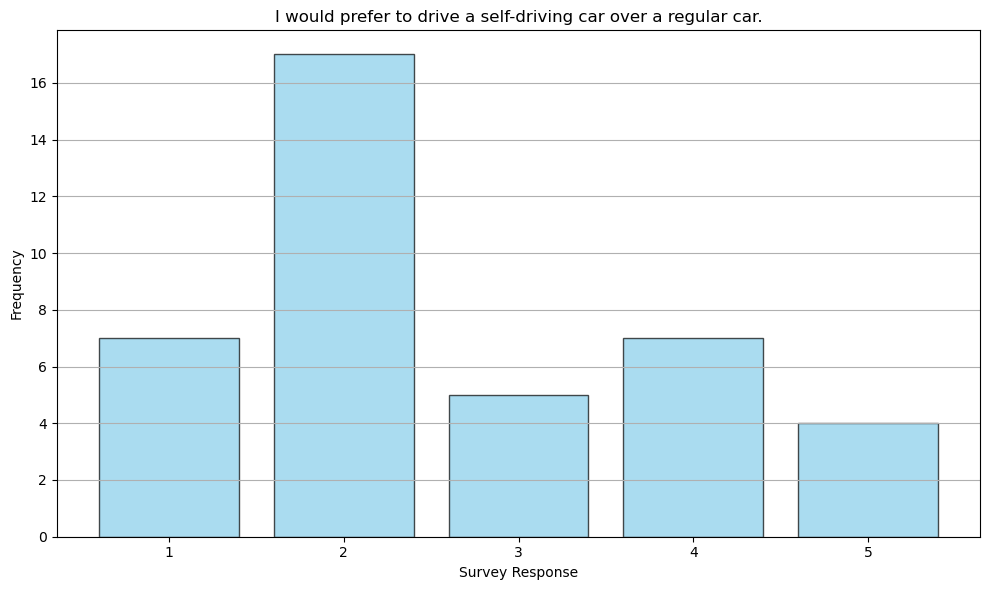

In [39]:
frequency_of_responses_to_survey('I would prefer to drive a self-driving car over a regular car.')

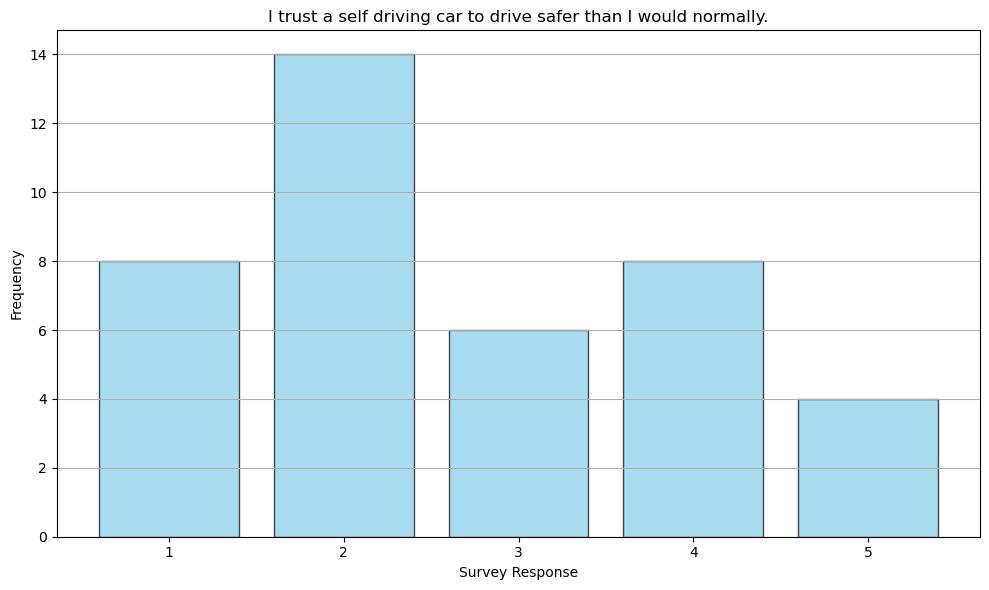

In [40]:
frequency_of_responses_to_survey('I trust a self driving car to drive safer than I would normally.')

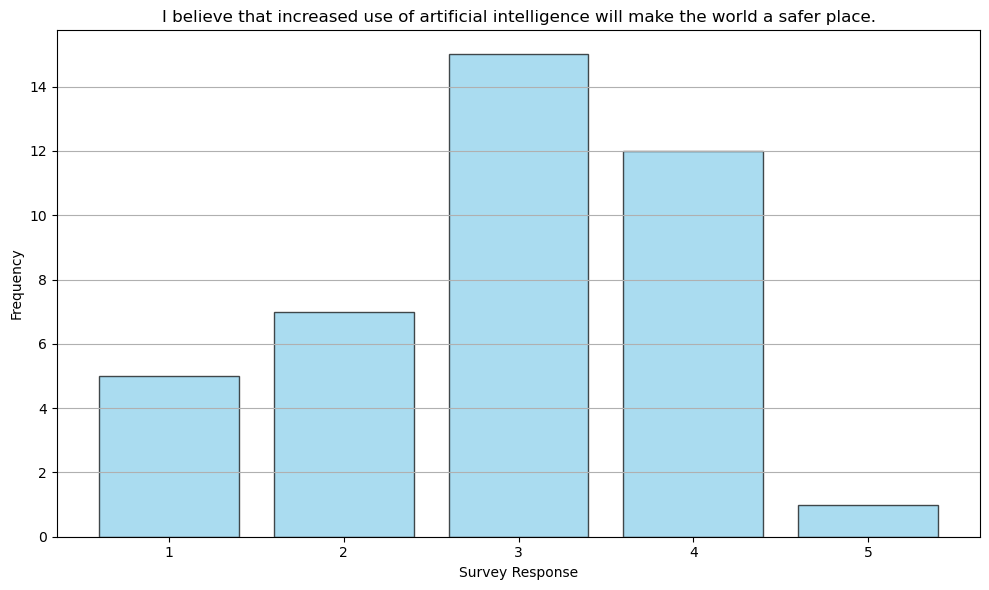

In [41]:
frequency_of_responses_to_survey('I believe that increased use of artificial intelligence will make the world a safer place.')

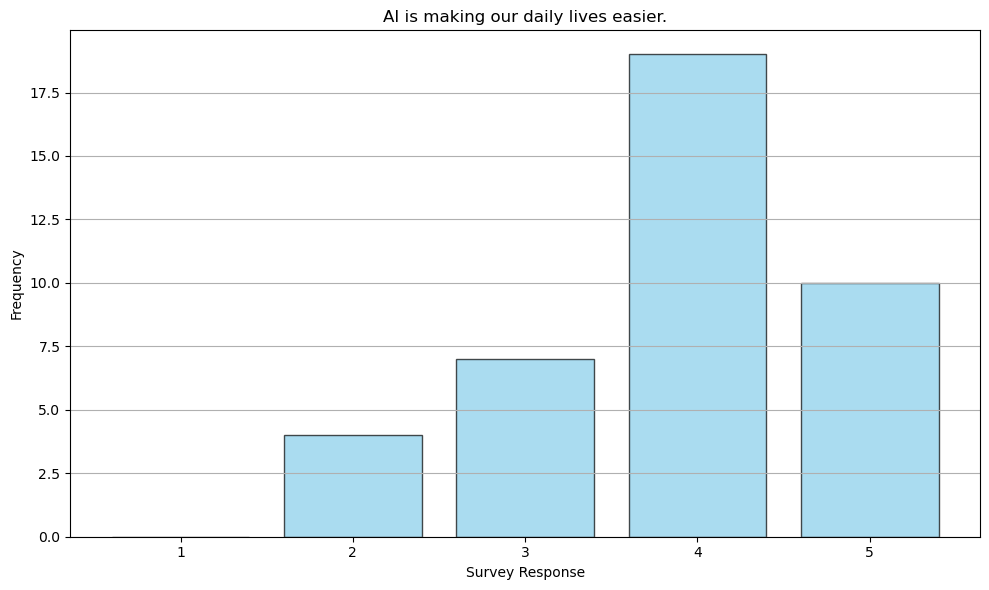

In [42]:
frequency_of_responses_to_survey('AI is making our daily lives easier.')

In [43]:
import subprocess
import re

# Run pip freeze and capture output
result = subprocess.run(['pip', 'freeze'], capture_output=True, text=True)

# Use a regex to remove lines that include 'file:///'
cleaned_output = re.sub(r' @ file://[^\n]+', '', result.stdout)

# Write the cleaned output to a new requirements.txt file
with open('requirements.txt', 'w') as f:
    f.write(cleaned_output)

print("Cleaned requirements.txt has been generated.")

Cleaned requirements.txt has been generated.
